# Intensity vs. Sdd (Both Total and Only Fetal) Plus Their Ratio
## Filter the Proper Raw Files

In [1]:
# Fetch the RAW data
from pathlib import Path
from glob import glob
import pandas as pd
import json
from tfo_sim.misc import generate_sdd_column    # Ignore the error, it is a bug in VSCode
import matplotlib.pyplot as plt
import seaborn as sns

# Get all the raw files
raw_file_path = Path(r'/home/rraiyan/simulations/tfo_sim/data/dan_iccps_pencil2')
raw_files = list(raw_file_path.glob("*.pkl"))  # RAW files are in pickle format
raw_files = [Path(file) for file in raw_files]

# Filter
chosen_wall_thicknesses = [8, 10, 12]
chosen_wavelength = 735
chosen_files = list(filter(lambda x: int(x.stem.split('_')[-1]) in chosen_wall_thicknesses, raw_files))
chosen_files = list(filter(lambda x: int(x.stem.split('_')[-3]) == chosen_wavelength, chosen_files))
config_files = [x.with_suffix('.json') for x in chosen_files]
print(chosen_files)

[PosixPath('/home/rraiyan/simulations/tfo_sim/data/dan_iccps_pencil2/dan_iccps_pencil_wave_735_dermis_12.pkl'), PosixPath('/home/rraiyan/simulations/tfo_sim/data/dan_iccps_pencil2/dan_iccps_pencil_wave_735_dermis_10.pkl'), PosixPath('/home/rraiyan/simulations/tfo_sim/data/dan_iccps_pencil2/dan_iccps_pencil_wave_735_dermis_8.pkl')]


## Get the Raw DataFrame and the corresponding mu_a Values

In [2]:
# Get Optical Properties
from typing import List
from tfo_sim.model_creation.models import DanModel4LayerX
from tfo_sim.model_creation import SimulationParameters

all_sdd = []
raw_data_array: List[pd.DataFrame] = []
all_mu_a = []
all_ppath_columns = []

for file in chosen_files:
    raw_data = pd.read_pickle(file)    
    all_ppath_columns = list(filter(lambda x: 'ppath' in x, raw_data.columns))
    raw_data['Total ppath'] = raw_data[all_ppath_columns].sum(axis=1)
    raw_data['SDD'] = generate_sdd_column(raw_data).astype(int)
    all_sdd = raw_data['SDD'].unique()
    raw_data_array.append(raw_data)
    
    # mu_a    
    wavelength = float(file.name.split('_')[-3])
    sim_params = SimulationParameters(wavelength=wavelength)
    tissue_model = DanModel4LayerX(sim_params)
    props = tissue_model.get_optical_properties()
    mu_a = [layer['mua'] for layer in props]
    mu_a = mu_a[1:]     # Drop Air layer
    all_mu_a.append(mu_a)

## Calculate Intensity(Inplace)

In [3]:
import torch
for raw_data, mu_a in zip(raw_data_array, all_mu_a):
    ppaths = torch.tensor(raw_data[all_ppath_columns].values).cuda()
    mu_a_tensor = torch.tensor(mu_a).reshape(1, -1).cuda()
    photon_intensity = torch.exp(torch.sum(-ppaths * mu_a_tensor, dim=1)).cpu().numpy()
    raw_data['Intensity'] = photon_intensity

## Merging Data

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt 
from inverse_modelling_tfo.data.intensity_normalization import config_based_normalization 

df = pd.DataFrame(columns=['Intensity', 'SDD', 'Fetal Depth', 'Wavelength', 'Intensity Type'])
# Take Intensity Sum per SDD and put them onto a DataFrame
for raw_data, config in zip(raw_data_array, config_files):
    # Normalize the Intensity
    config_based_normalization(raw_data, config)
    wavelength = int(config.stem.split('_')[-3])
    wall_thickness = int(config.stem.split('_')[-1])
    total_intensity = raw_data.groupby('SDD')['Intensity'].sum()
    total_intensity = total_intensity.reset_index()
    total_intensity['Fetal Depth'] = wall_thickness + 6
    total_intensity['Wavelength'] = wavelength
    total_intensity['Intensity Type'] = 'Total Intensity'
    df = pd.concat([df, total_intensity])
    
    # Fetal Sensitive Intensity
    fetal_sensitive_intensity = raw_data[raw_data['L4 ppath'] > 0].groupby('SDD')['Intensity'].sum()
    fetal_sensitive_intensity = fetal_sensitive_intensity.reset_index()
    fetal_sensitive_intensity['Fetal Depth'] = wall_thickness + 6
    fetal_sensitive_intensity['Wavelength'] = wavelength
    fetal_sensitive_intensity['Intensity Type'] = 'Fetal Sensitive Intensity'
    df = pd.concat([df, fetal_sensitive_intensity])

## Plotting

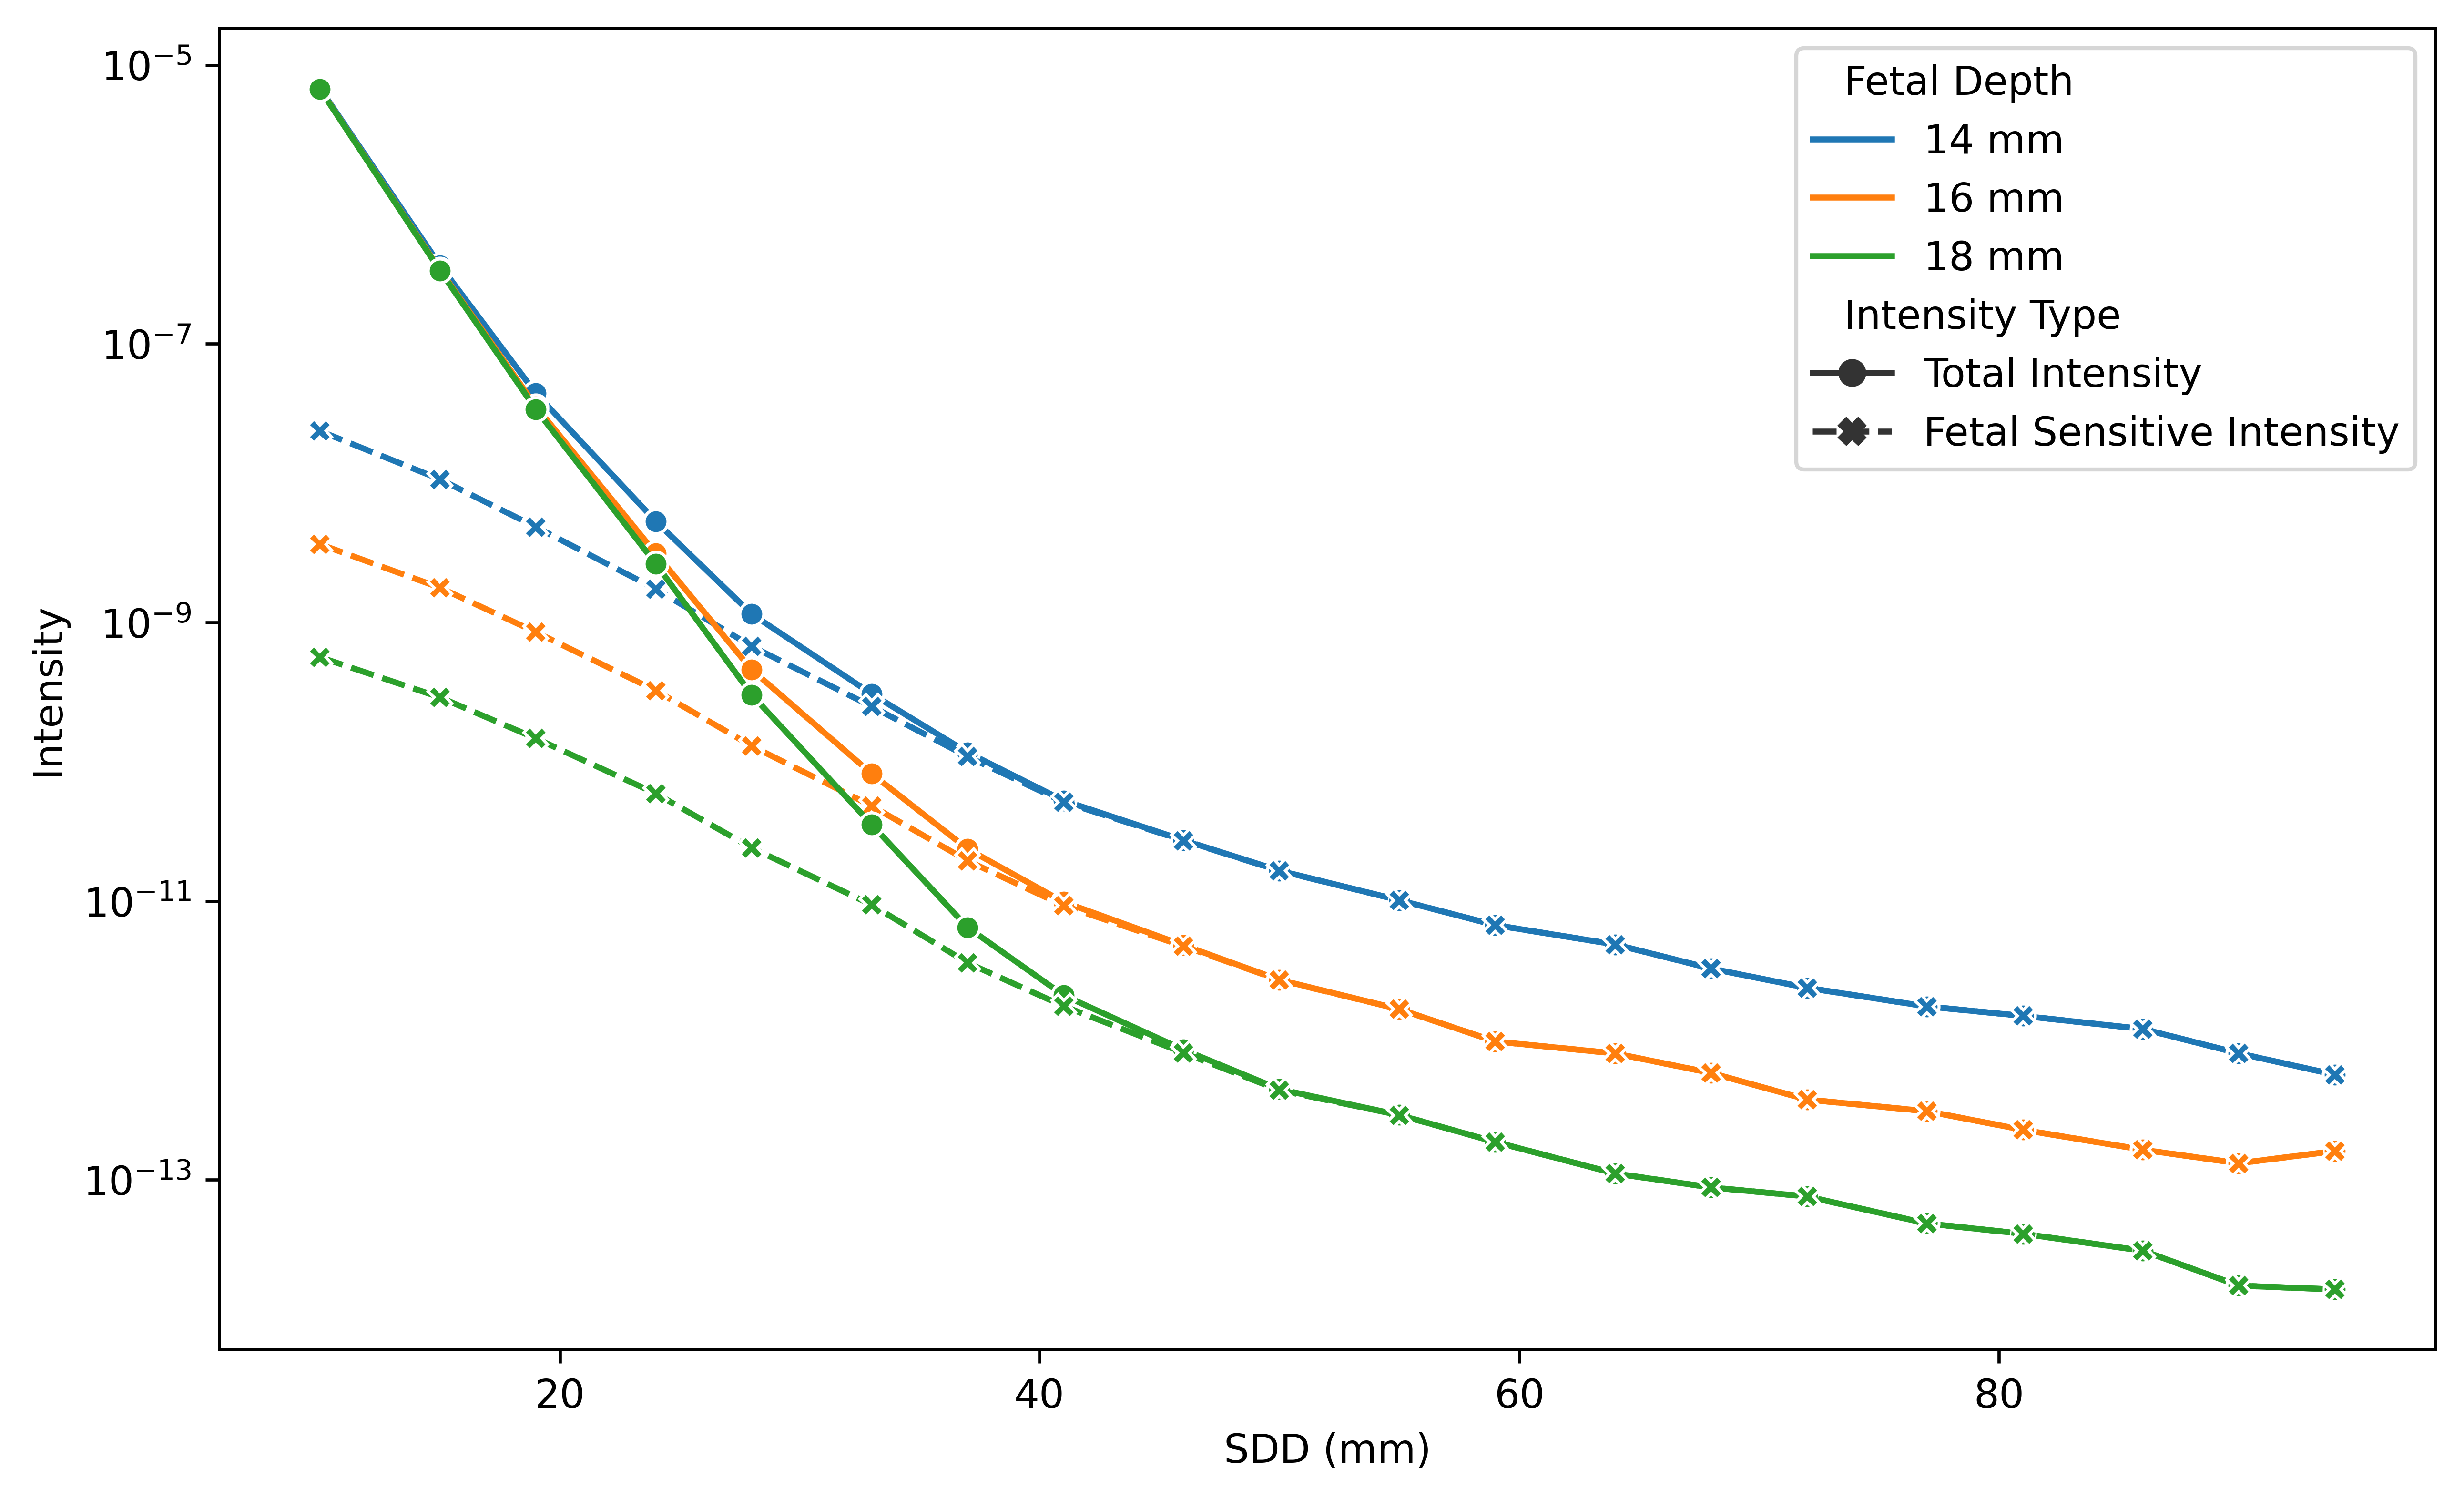

In [5]:
# Plotting Specific Edits
df_to_plot = df.copy()
# Write mm at the end of Fetal Depth for all the values
df_to_plot['Fetal Depth'] = df_to_plot['Fetal Depth'].astype(str) + ' mm'

# Define the desired order of fetal depths
fetal_depth_order = sorted(df_to_plot['Fetal Depth'].unique(), key=lambda x: float(x.split()[0]))

# Plotting
plt.figure(figsize=(10, 6), dpi=600)
sns.lineplot(data=df_to_plot, x='SDD', y='Intensity', hue='Fetal Depth', hue_order=fetal_depth_order, style='Intensity Type', markers=True)
plt.yscale('log')
plt.ylabel('Intensity')
plt.xlabel('SDD (mm)')
plt.show()

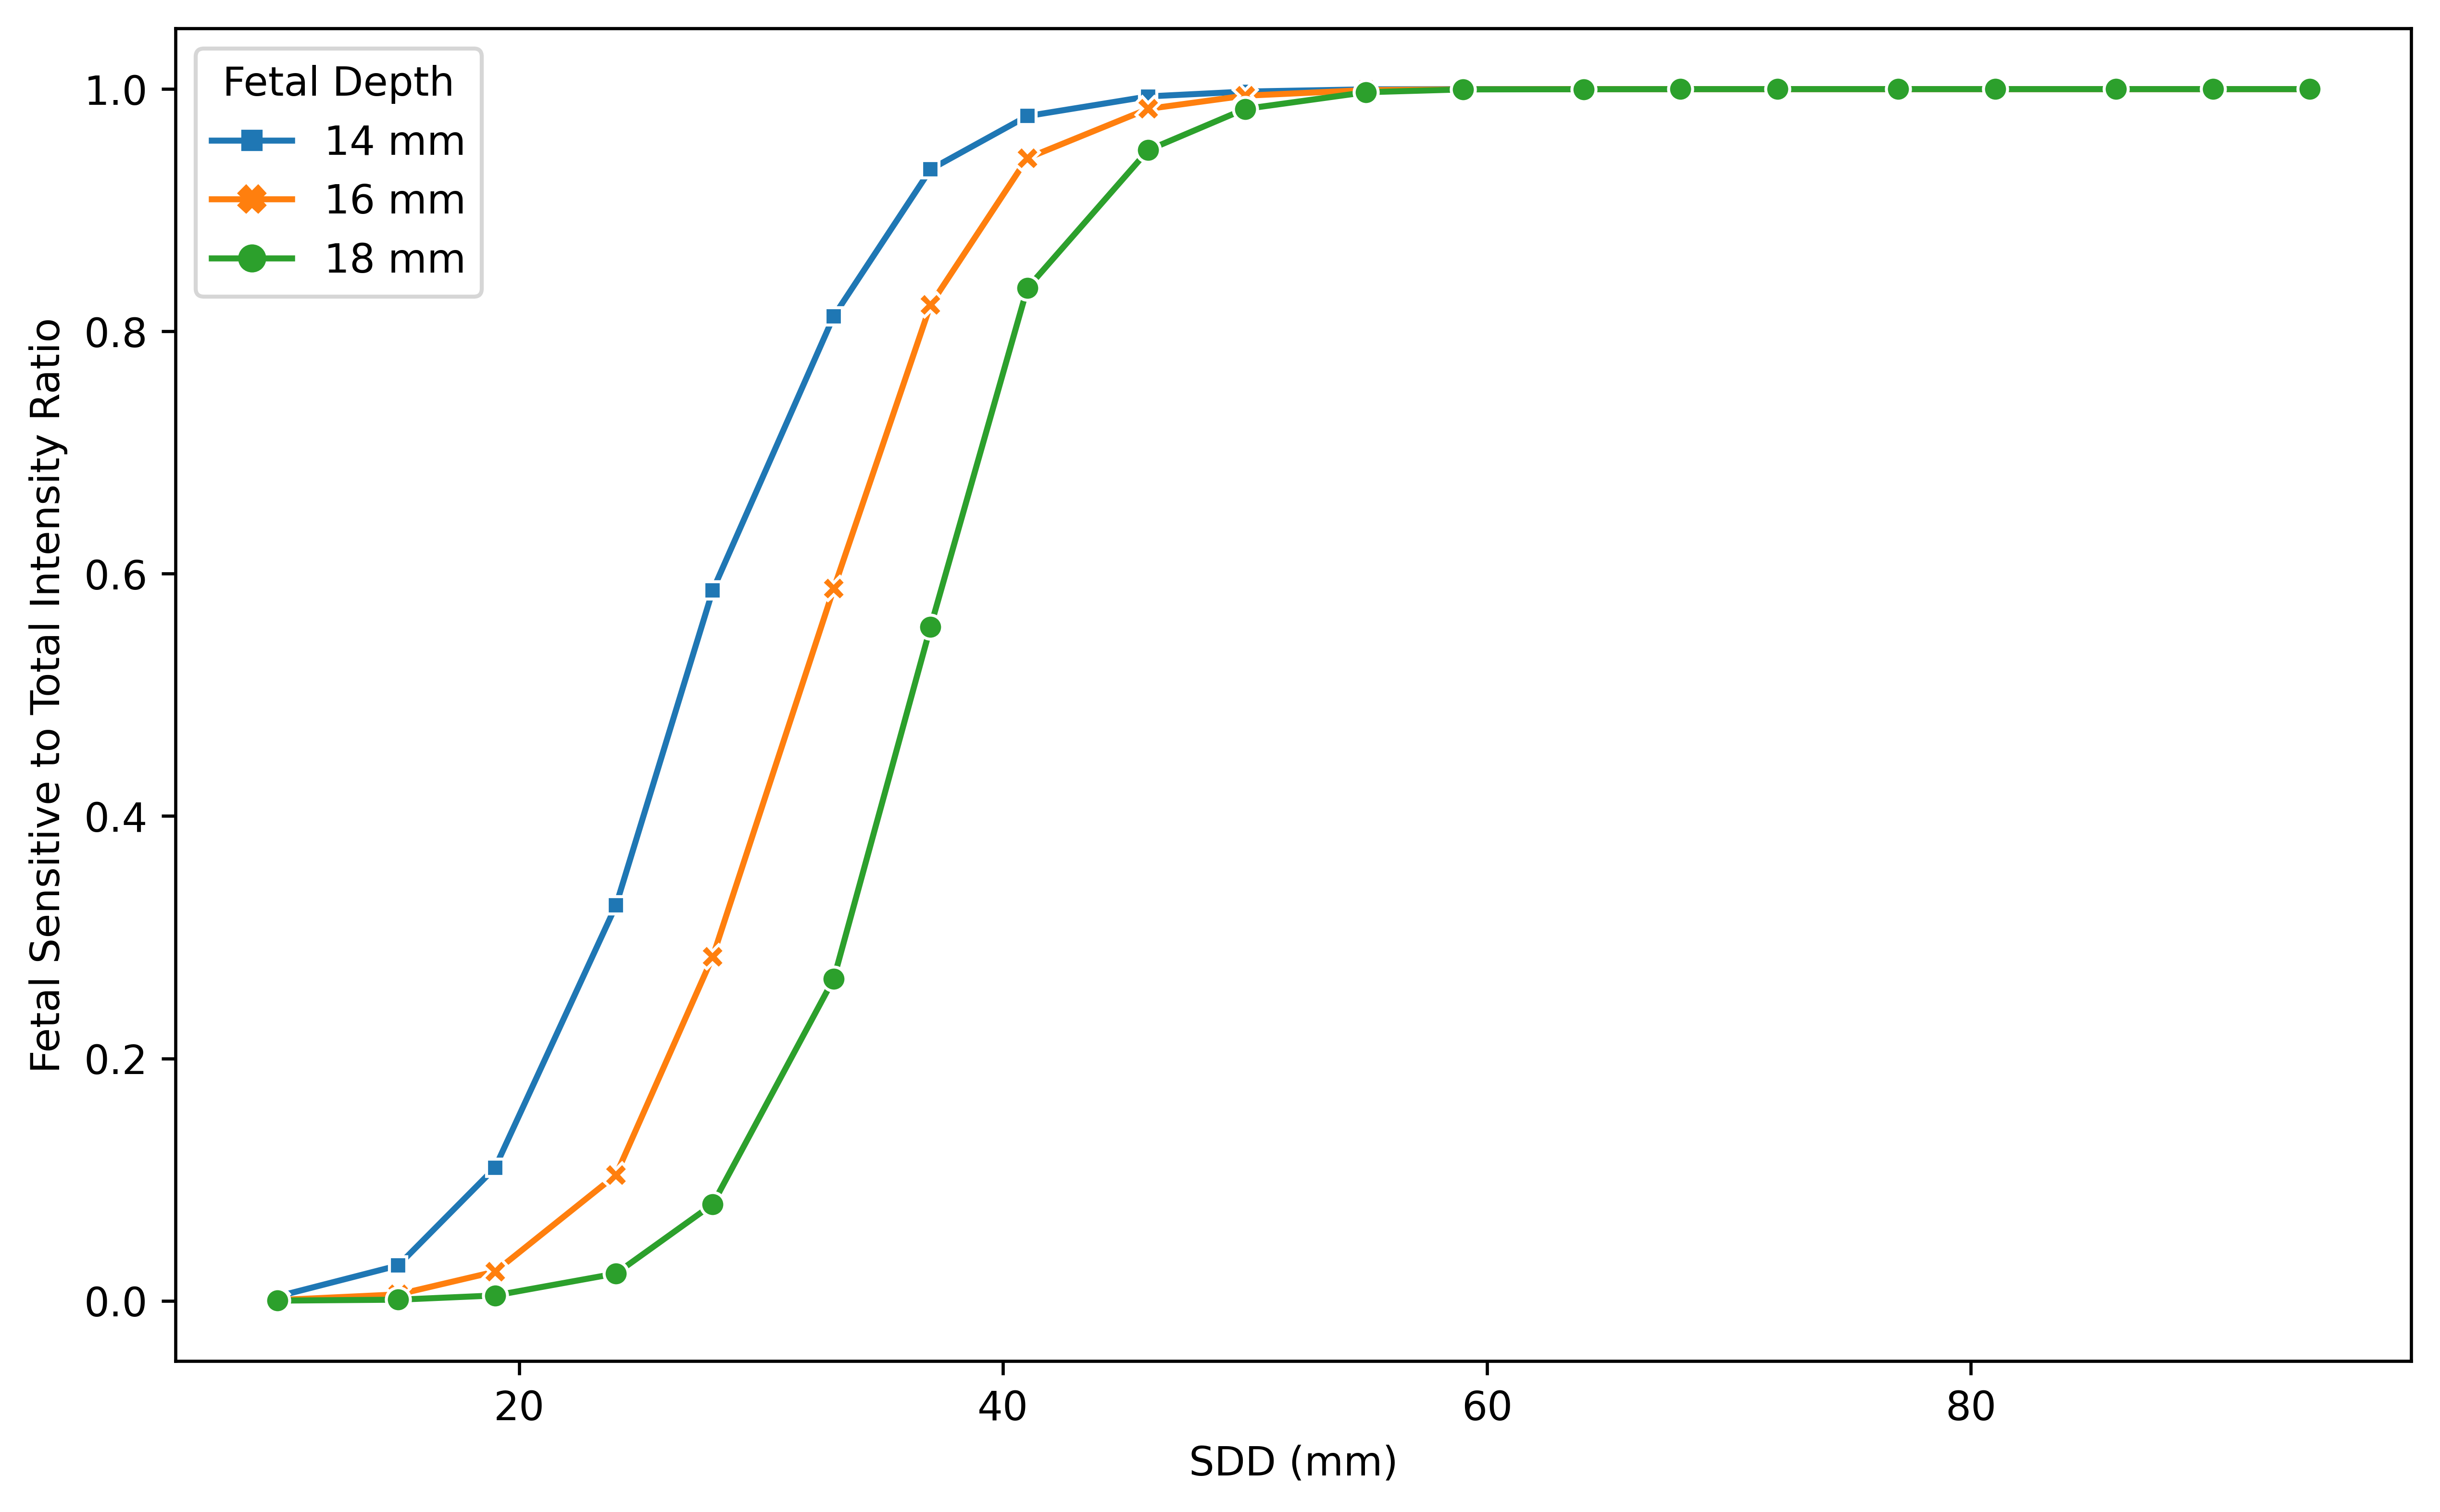

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get the Ratio of Fetal to Total Intensity
total_intensity = df_to_plot[df_to_plot["Intensity Type"] == "Total Intensity"]
fetal_intensity = df_to_plot[df_to_plot["Intensity Type"] == "Fetal Sensitive Intensity"]
merged = pd.merge(
    total_intensity, fetal_intensity, on=["SDD", "Fetal Depth", "Wavelength"], suffixes=("_Total", "_Fetal")
)
merged["Fetal Sensitive to Total Intensity Ratio"] = merged["Intensity_Fetal"] / merged["Intensity_Total"]

# Define the desired order of fetal depths
fetal_depth_order = sorted(merged["Fetal Depth"].unique(), key=lambda x: float(x.split()[0]))

plt.figure(figsize=(10, 6), dpi=600)
sns.lineplot(
    data=merged,
    x="SDD",
    y="Fetal Sensitive to Total Intensity Ratio",
    hue="Fetal Depth",
    hue_order=fetal_depth_order,
    style="Fetal Depth",
    markers=True,
    dashes=False,
)
plt.ylabel("Fetal Sensitive to Total Intensity Ratio")
plt.xlabel("SDD (mm)")
plt.show()